# Exercise 2: Topic Model Inference in LDA

First, let's import the Python bindings for MeTA:

In [1]:
import metapy

If you don't have `metapy` installed, you can install it with a

```bash
pip install metapy
```

on the command line on Linux, macOS, or Windows for either Python 2.7 or Python 3.x. (I will be using Python 3.6 in this tutorial.)

Double-check that you are running the latest version. Right now, that should be `0.2.10`.

In [2]:
metapy.__version__

'0.2.11'

Now, let's set MeTA to log to standard error so we can see progress output for long-running commands. (Only do this once, or you'll get double the output.)

In [3]:
metapy.log_to_stderr()

Now, let's download all of the files we need for the tutorial.

In [4]:
import urllib.request
import os
import tarfile

if not os.path.exists('sigir18-tutorial.tar.gz'):
    urllib.request.urlretrieve('https://meta-toolkit.org/data/2018-06-25/sigir18-tutorial.tar.gz',
                               'sigir18-tutorial.tar.gz')
    
if not os.path.exists('data'):
    with tarfile.open('sigir18-tutorial.tar.gz', 'r:gz') as files:
        files.extractall()

The tutorial files come with a dataset consisting of four years of NIPS proceedings (full text): 2002, 2007, 2012, and 2017.

To start, we first want to understand what topics are being discussed in NIPS in these for years. To do that, we'll first index the dataset in the `ForwardIndex` format (we want to map documents to the terms that they contain).

In [5]:
fidx = metapy.index.make_forward_index('nips.toml')

1530029662: [info]     Creating forward index: nips-idx/fwd (/tmp/pip-req-build-s8007td9/deps/meta/src/index/forward_index.cpp:239)
 > Tokenizing Docs: [===================================>    ]  88% ETA 00:00:00   
1530029664: [warning]  Empty document (id = 1435) generated! (/tmp/pip-req-build-s8007td9/deps/meta/src/index/forward_index.cpp:335)
 > Tokenizing Docs: [========================================] 100% ETA 00:00:00 
 > Merging: [================================================] 100% ETA 00:00:00 
1530029664: [info]     Done creating index: nips-idx/fwd (/tmp/pip-req-build-s8007td9/deps/meta/src/index/forward_index.cpp:278)


Now, let's load in all of the documents into memory so we can start to infer a topic model. I'm going to load them in as a `MulticlassDataset` because each document here has been associated with a label (the year it came from), but you could also load them in as just a standard `Dataset` with no associated labels if you don't plan to use them.

In [6]:
dset = metapy.classify.MulticlassDataset(fidx)

 > Loading instances into memory: [==========================] 100% ETA 00:00:00 


With the documents loaded into memory, we can start to run LDA inference on them to infer the topics and their coverage in each of the documents. There are several choices for inference algorithm in MeTA, so in general you can just pick your favorite. Here, I'm going to pick a parallelized version of Gibbs sampling.

The below will run the sampler for either 1000 iterations or until the log likelihood ($\log P(W \mid Z)$) stabilizes, whichever comes first. (If you want to disable the convergence checking and just run the sampler for a fixed number of iterations, you can add the parameter `convergence=0`.)

In [7]:
model = metapy.topics.LDAParallelGibbs(docs=dset, num_topics=10, alpha=0.1, beta=0.1)
model.run(num_iters=1000)
model.save('lda-pgibbs-nips')

Initialization log likelihood (log P(W|Z)): -3.05507e+07                          
Iteration 1 log likelihood (log P(W|Z)): -3.05155e+07                              
Iteration 2 log likelihood (log P(W|Z)): -3.04318e+07                              
Iteration 3 log likelihood (log P(W|Z)): -3.03566e+07                              
Iteration 4 log likelihood (log P(W|Z)): -3.02892e+07                              
Iteration 5 log likelihood (log P(W|Z)): -3.0229e+07                               
Iteration 6 log likelihood (log P(W|Z)): -3.01748e+07                              
Iteration 7 log likelihood (log P(W|Z)): -3.0123e+07                              
Iteration 8 log likelihood (log P(W|Z)): -3.00742e+07                             
Iteration 9 log likelihood (log P(W|Z)): -3.00266e+07                             
Iteration 10 log likelihood (log P(W|Z)): -2.99788e+07                            
Iteration 11 log likelihood (log P(W|Z)): -2.99365e+07                           

Iteration 98 log likelihood (log P(W|Z)): -2.89316e+07                           
Iteration 99 log likelihood (log P(W|Z)): -2.89272e+07                            
Iteration 100 log likelihood (log P(W|Z)): -2.89221e+07                           
Iteration 101 log likelihood (log P(W|Z)): -2.89194e+07                           
Iteration 102 log likelihood (log P(W|Z)): -2.89157e+07                           
Iteration 103 log likelihood (log P(W|Z)): -2.89128e+07                           
Iteration 104 log likelihood (log P(W|Z)): -2.89098e+07                           
Iteration 105 log likelihood (log P(W|Z)): -2.89056e+07                           
Iteration 106 log likelihood (log P(W|Z)): -2.89036e+07                           
Iteration 107 log likelihood (log P(W|Z)): -2.88998e+07                           
Iteration 108 log likelihood (log P(W|Z)): -2.88973e+07                           
Iteration 109 log likelihood (log P(W|Z)): -2.88933e+07                           
Itera

Once the above converges, it will save the results to disk. We can load the results into memory for inspection by loading an instance of the `TopicModel` class:

In [8]:
model = metapy.topics.TopicModel('lda-pgibbs-nips')

 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 
 > Loading document topic probabilities: [===================] 100% ETA 00:00:00 


What do the topics discussed in NIPS over the last two decades roughly look like?

In [9]:
for topic in range(0, model.num_topics()):
    print("Topic {}:".format(topic + 1))
    for tid, val in model.top_k(topic, 10, metapy.topics.BLTermScorer(model)):
        print("{}: {}".format(fidx.term_text(tid), val))
    print("======\n")

Topic 1:
model: 0.047845971473469015
item: 0.036164145122550555
topic: 0.03582248886330763
document: 0.0301900041003383
latent: 0.029632168260620255
word: 0.02883241321447034
user: 0.0262748217085278
languag: 0.021573178212931057
lda: 0.014349119364181297
dirichlet: 0.013994334038283054

Topic 2:
neuron: 0.10418809366208093
spike: 0.07989410305538147
stimulus: 0.03402944466933788
respons: 0.027507819831649183
cell: 0.024650823093126214
signal: 0.023464992947839394
brain: 0.021329972080580163
time: 0.017871200820055985
fire: 0.017004659525601817
stimuli: 0.016437347395342597

Topic 3:
polici: 0.18494968655605182
action: 0.09615364214854322
reward: 0.08377584211666766
agent: 0.0808785827262104
game: 0.05217837257413512
state: 0.04843198689741257
reinforc: 0.04066073218825473
trajectori: 0.03331838788594098
mdp: 0.02327701848342051
player: 0.022277731661894288

Topic 4:
kernel: 0.058391015341538656
label: 0.05470488694787862
classifi: 0.04543920685948777
classif: 0.031377691511149046
feat

# Exercise 3: Text Mining using Topic Models

## Topics over Time

An interesting "mining" question to ask on top of this is whether or not the topics used in NIPS have changed over time. Are certain topics exhibited only in the earlier years, or vice-versa?

To do this, let's take a look at the other output of LDA---the topic proportion vectors associated with each document. Since each document also has a label in our dataset, we can create plots for each topic to see the number of documents that mention a specific topic in a specific year, and to what degree.

We'll start by creating a simple dataset with `pandas`:

In [10]:
import pandas as pd

data = []
for doc in dset:
    proportions = model.topic_distribution(doc.id)
    data.append([dset.label(doc)] + [proportions.probability(i) for i in range(0, model.num_topics())])
df = pd.DataFrame(data, columns=['label'] + ["Topic {}".format(i + 1) for i in range(0, model.num_topics())])

Now, let's plot the results. There a lot of ways to do this, but here I'm going to use a "swarm plot" so we can see where each and every document falls.

Topic 1


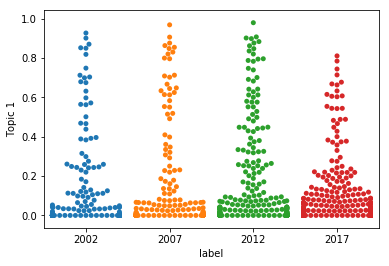

Topic 2


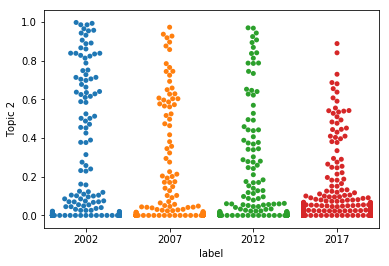

Topic 3


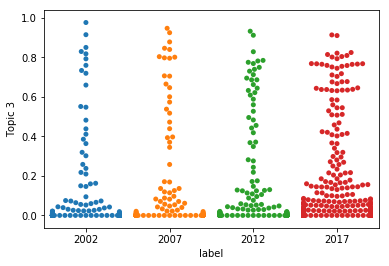

Topic 4


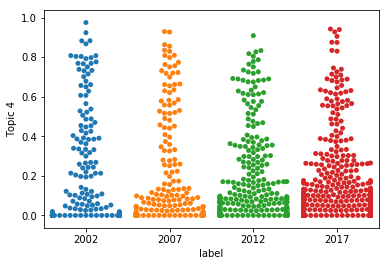

Topic 5


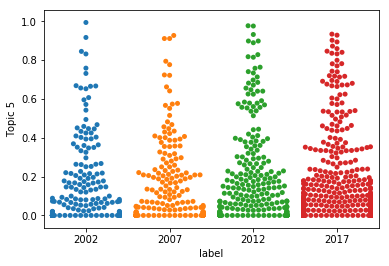

Topic 6


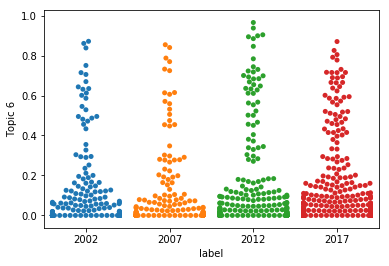

Topic 7


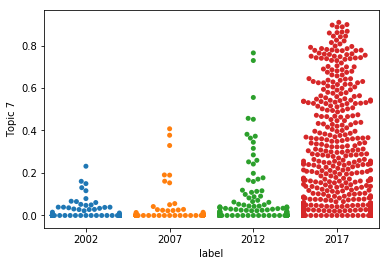

Topic 8


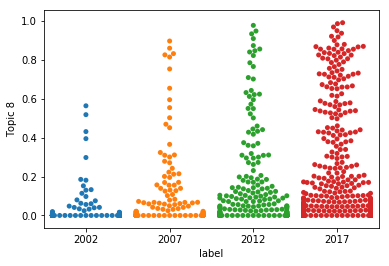

Topic 9


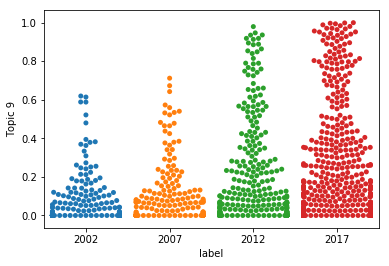

Topic 10


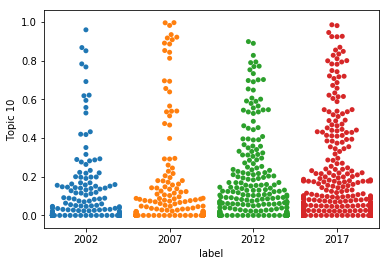

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(0, model.num_topics()):
    print("Topic {}".format(i + 1))
    sns.swarmplot(data=df, x='label', y="Topic {}".format(i + 1))
    plt.show()

## Topic Inference (Unseen Document)

Let's try to figure out what topics are mentioned in a previously unseen document.

In [12]:
doc = metapy.index.Document()
with open('data/6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt') as f:
    doc.content(f.read())
print("{}...".format(doc.content()[0:500]))

Scan Order in Gibbs Sampling: Models in Which it
Matters and Bounds on How Much
Bryan He, Christopher De Sa, Ioannis Mitliagkas, and Christopher Ré
Stanford University
{bryanhe,cdesa,imit,chrismre}@stanford.edu

Abstract
Gibbs sampling is a Markov Chain Monte Carlo sampling technique that iteratively
samples variables from their conditional distributions. There are two common scan
orders for the variables: random scan and systematic scan. Due to the benefits
of locality in hardware, systematic s...


We first need to transform the unseen document into the same term-id space used by the topic model.

In [13]:
dvec = fidx.tokenize(doc)

...and then we can create an inferencer on top of our topic model output to infer the topic coverage for this new document:

In [15]:
inferencer = metapy.topics.GibbsInferencer('lda-pgibbs-nips.phi.bin', alpha=0.1)
props = inferencer.infer(dvec, max_iters=100, rng_seed=42)
print(props)

<metapy.stats.Multinomial {0: 0.125214, 1: 0.000036, 2: 0.240763, 3: 0.000036, 4: 0.161947, 5: 0.020007, 6: 0.000036, 7: 0.058167, 8: 0.020007, 9: 0.373787}>


 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 


## Classification with Topic Features

The topic proportion vectors are also often used as input to a classifier. In our case, since we see some differences between the years 2002 and 2017 in terms of topical coverage, let's see if we can learn to separate documents that were written in 2002 from documents that were written in 2017 on the basis of their topic proportions alone.

In [16]:
# First, create a lightweight view for shuffling
shuffled_view = metapy.classify.MulticlassDatasetView(dset)
shuffled_view.shuffle()

# this dataset will use unigram words as features
words_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    dset.total_features(),
    lambda doc: metapy.learn.FeatureVector(doc.weights),
    lambda doc: dset.label(doc)
)

# this dataset will use topic proportions as features
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

We'll use a 50/50 training/test split setup.

In [17]:
words_train = words_dset[0:int(len(words_dset)/2)]
words_test = words_dset[int(len(words_dset)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [18]:
def make_linear_svm(training):
    return metapy.classify.OneVsAll(training, metapy.classify.SGD, loss_id='hinge')

words_sgd = make_linear_svm(words_train)
topics_sgd = make_linear_svm(topics_train)

print("Words:")
mtrx = words_sgd.test(words_test)
print(mtrx)
mtrx.print_stats()

print("======")
print("Topics:")
mtrx = topics_sgd.test(topics_test)
print(mtrx)
mtrx.print_stats()

Words:

           2002     2017     
         ------------------
    2002 | 0.883    0.117    
    2017 | 0.0392   0.961    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.883       0.883       0.883       0.251       
2017        0.961       0.961       0.961       0.749       
------------------------------------------------------------
Total       0.941       0.941       0.941       
------------------------------------------------------------
443 predictions attempted, overall accuracy: 0.941

Topics:

           2002     2017     
         ------------------
    2002 | 0.613    0.387    
    2017 | 0.0753   0.925    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.667       0.731   

While we don't beat unigram words, we still do very well for a model that is only using 10 features compared to the tens of thousands used by the words model:

In [19]:
fidx.unique_terms()

66479

We can also try a straight multiclass classification problem: given a document, predect the year from the topic proportions alone.

In [20]:
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

words_train = shuffled_view[0:int(len(shuffled_view)/2)]
words_test = shuffled_view[int(len(shuffled_view)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [21]:
words_svm = make_linear_svm(words_train)
topics_svm = make_linear_svm(topics_train)

words_mtrx = words_svm.test(words_test)
topics_mtrx = topics_svm.test(topics_test)

print("Words:")
print(words_mtrx)
words_mtrx.print_stats()

print("========")
print("Topics:")
print(topics_mtrx)
topics_mtrx.print_stats()

Words:

           2002     2007     2012     2017     
         ------------------------------------
    2002 | 0.667    0.176    0.0926   0.0648   
    2007 | 0.314    0.195    0.398    0.0932   
    2012 | 0.107    0.16     0.487    0.246    
    2017 | 0.0217   0.00619  0.0774   0.895    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.59        0.529       0.667       0.147       
2007        0.24        0.311       0.195       0.16        
2012        0.506       0.526       0.487       0.254       
2017        0.855       0.819       0.895       0.439       
------------------------------------------------------------
Total       0.633       0.62        0.645       
------------------------------------------------------------
736 predictions attempted, overall accuracy: 0.645

Topics:

           2002     2007     2012     2017   

This is quite a bit harder!